In [ ]:
import cv2
import numpy as np
import sys
import os

base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(base_dir)

sys.path.append(base_dir)

def cropped_generate(input_dir, output_dir):
    # Carrega a imagem
    nome_arquivo = os.path.basename(input_dir)  
    nome_sem_extensao = os.path.splitext(nome_arquivo)[0]
    imagem = cv2.imread(input_dir)

    # Converte para HSV
    hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

    # Intervalo para tons de marrom
    limite_inferior = np.array([10, 100, 20])
    limite_superior = np.array([20, 255, 200])
    mascara_marrom = cv2.inRange(hsv, limite_inferior, limite_superior)

    # Encontrar contornos
    contornos, _ = cv2.findContours(mascara_marrom, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Cópia da imagem original
    imagem_quadrados = imagem.copy()
    altura, largura = imagem.shape[:2]

    padding = 20
    margem_borda = 10
    contador = 1

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        x, y, w, h = cv2.boundingRect(contorno)
        if area > 500 and w > 150:
            contador += 1
            lado = max(w, h)
            centro_x = x + w // 2
            centro_y = y + h // 2
            novo_x = centro_x - lado // 2
            novo_y = centro_y - lado // 2

            # Ajusta com padding e mantém dentro da imagem
            novo_x_pad = max(novo_x - padding, 0)
            novo_y_pad = max(novo_y - padding, 0)
            fim_x_pad = min(novo_x + lado + padding, largura)
            fim_y_pad = min(novo_y + lado + padding, altura)

            # Verifica se está pelo menos a margem_borda pixels da borda da imagem
            if (novo_x_pad < margem_borda or novo_y_pad < margem_borda or
                fim_x_pad > largura - margem_borda or fim_y_pad > altura - margem_borda):
                # Ignora esta região, não desenha nem gera imagem
                continue

            lado_pad = min(fim_x_pad - novo_x_pad, fim_y_pad - novo_y_pad)

            # Marcar Imagem
            # cv2.rectangle(imagem_quadrados, 
            #               (novo_x, novo_y), (novo_x + lado, novo_y + lado), 
            #               (255, 0, 0), 
            #               2
            # ) # Desenhar o quadrado original (sem padding) - opcional

            
            # cv2.rectangle(imagem_quadrados, 
            #               (novo_x_pad, novo_y_pad), (novo_x_pad + lado_pad, novo_y_pad + lado_pad), 
            #               (0, 255, 0), 
            #               2
            # ) # Desenhar o quadrado com padding - opcional (em verde)

            # Redimensionar para 640x640
            recorte = imagem[novo_y_pad:novo_y_pad + lado_pad, novo_x_pad:novo_x_pad + lado_pad]
            imagem_expandidada = cv2.resize(recorte, (640, 640), interpolation=cv2.INTER_LINEAR)

            # Salvar a imagem expandida
            caminho_salvar = os.path.join(output_dir, f'{nome_sem_extensao}_cropped_{contador}.jpg')
            cv2.imwrite(caminho_salvar, imagem_expandidada)

            # Mostrar cada imagem expandida numa janela separada
            # cv2.imshow(f'Marcacao {contador}', imagem_expandidada)

    # Mostrar a imagem com quadrados desenhados
    #cv2.imshow('Quadrados Perfeitos em Áreas Marrons com Padding', imagem_quadrados)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

c:\ProjetosPython\PICOS


In [ ]:
input_dir = os.path.join(base_dir, 'data', 'inputs', 'train_images', 'ImagensOriginais_gx')
output_dir = os.path.join(base_dir, 'data', 'outputs', 'cropped_generate')

# Criar pasta de saída caso não exista
os.makedirs(output_dir, exist_ok=True)

# Listar arquivos .jpg na pasta de entrada
for arquivo in os.listdir(input_dir):
    if arquivo.lower().endswith('.jpg'):
        caminho_arquivo = os.path.join(input_dir, arquivo)
        print(f'Processando: {arquivo}')
        cropped_generate(caminho_arquivo, output_dir)

print('Processamento finalizado.')

In [68]:
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(base_dir)

sys.path.append(base_dir)

def marcar_slug(input_dir, output_dir):
    # Carrega a imagem
    nome_arquivo = os.path.basename(input_dir)  
    nome_sem_extensao = os.path.splitext(nome_arquivo)[0]
    imagem = cv2.imread(input_dir)

    # Adiciona padding de 20 pixels (preto) ao redor da imagem
    padding = 20
    imagem = cv2.copyMakeBorder(
        imagem,
        top=padding,
        bottom=padding,
        left=padding,
        right=padding,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # Cor preta (BGR)
    )

    # Converte para HSV
    hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

    limite_inferior_marrom_escuro = np.array([0, 50, 20])     # Marrom mais escuro
    limite_superior_marrom_escuro = np.array([20, 255, 200])  # Marrom médio
    
    limite_inferior_marrom_claro = np.array([10, 30, 40])      # Marrom claro
    limite_superior_marrom_claro = np.array([25, 150, 255])   # Marrom muito claro

    # Cria máscaras para ambas as faixas de marrom
    mascara_marrom_escuro = cv2.inRange(hsv, limite_inferior_marrom_escuro, limite_superior_marrom_escuro)
    mascara_marrom_claro = cv2.inRange(hsv, limite_inferior_marrom_claro, limite_superior_marrom_claro)

    # Combina as máscaras
    mascara_combinada = cv2.bitwise_or(mascara_marrom_escuro, mascara_marrom_claro)

    # Operações morfológicas para melhorar a máscara
    kernel = np.ones((5,5), np.uint8)
    mascara_combinada = cv2.morphologyEx(mascara_combinada, cv2.MORPH_CLOSE, kernel)  # Fecha pequenos buracos
    mascara_combinada = cv2.morphologyEx(mascara_combinada, cv2.MORPH_OPEN, kernel)   # Remove ruídos

    # Encontrar contornos na máscara combinada
    contornos, _ = cv2.findContours(mascara_combinada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Cópia da imagem original
    imagem_quadrados = imagem.copy()
    altura, largura = imagem.shape[:2]

    padding = 20
    margem_borda = 10
    contador = 1

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        x, y, w, h = cv2.boundingRect(contorno)
        
        #if True:
        if area > 500 and w > 150:
            contador += 1
            lado = max(w, h)
            centro_x = x + w // 2
            centro_y = y + h // 2
            novo_x = centro_x - lado // 2
            novo_y = centro_y - lado // 2

            # Ajusta com padding e mantém dentro da imagem
            novo_x_pad = max(novo_x - padding, 0)
            novo_y_pad = max(novo_y - padding, 0)
            fim_x_pad = min(novo_x + lado + padding, largura)
            fim_y_pad = min(novo_y + lado + padding, altura)

            # Verifica se está pelo menos a margem_borda pixels da borda da imagem
            # if (novo_x_pad < margem_borda or novo_y_pad < margem_borda or
            #     fim_x_pad > largura - margem_borda or fim_y_pad > altura - margem_borda):
            #     # Ignora esta região, não desenha nem gera imagem
            #     continue

            lado_pad = min(fim_x_pad - novo_x_pad, fim_y_pad - novo_y_pad)

            # Marcar Imagem
            cv2.rectangle(imagem_quadrados, 
                          (novo_x, novo_y), (novo_x + lado, novo_y + lado), 
                          (255, 0, 0), 
                          2
            ) # Desenhar o quadrado original (sem padding) - opcional

            
            cv2.rectangle(imagem_quadrados, 
                          (novo_x_pad, novo_y_pad), (novo_x_pad + lado_pad, novo_y_pad + lado_pad), 
                          (0, 255, 0), 
                          2
            ) # Desenhar o quadrado com padding - opcional (em verde)

            # Mostrar cada imagem expandida numa janela separada
            imagem_rgb = cv2.cvtColor(imagem_quadrados, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.title(f"Marcacao")
    plt.imshow(imagem_rgb)
    plt.axis('off')  # Remove os eixos
    plt.show()

c:\ProjetosPython\PICOS


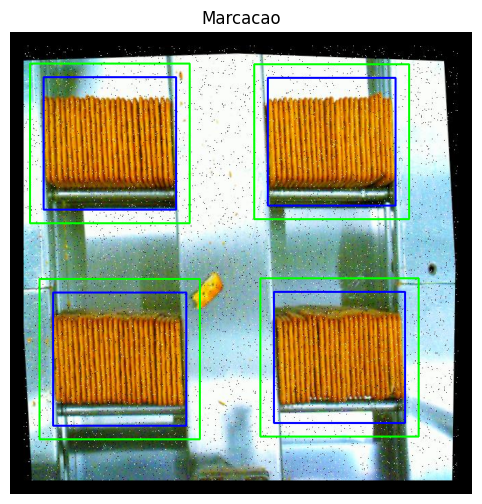

Processamento finalizado.


In [69]:
input_dir = os.path.join(base_dir, 'data', 'inputs', 'train_images', 'COCO_gx')
caminho_arquivo = os.path.join(input_dir, 'train\\frame_0003_jpg.rf.998bb71d00ed918b05bdfd981b68a83a.jpg')

output_dir = os.path.join(base_dir, 'data', 'outputs', 'cropped_generate')

# Criar pasta de saída caso não exista
os.makedirs(output_dir, exist_ok=True)

marcar_slug(input_dir=caminho_arquivo, output_dir = None)


print('Processamento finalizado.')